In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [2]:
df = pd.read_pickle("Data_allnum.pkl")

### Początkowe zestawienia

Zaczniemy od spojrzenia na dane przed przeprowadzeniem na nich działań. Pierwszym krokiem jest sprawdzenie, w których miastach jest największa ilość odejść klientów

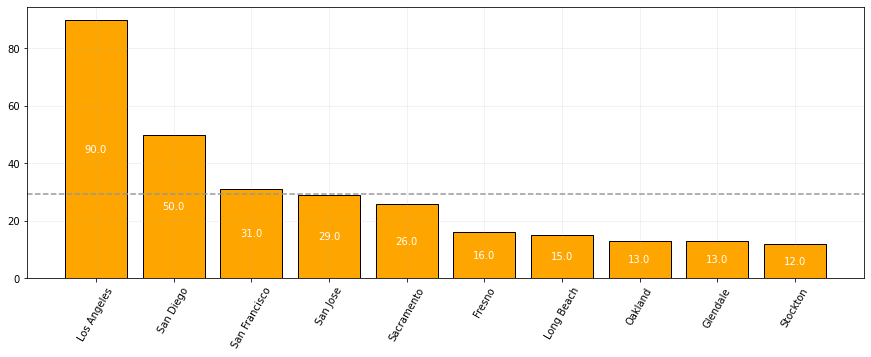

In [3]:
city_churn = df.groupby('City')['Churn Value'].agg(['sum', 'size'])
city_churn = city_churn[city_churn != 0].sort_values(by='sum', ascending=False)

X = city_churn.head(10).index
y = city_churn['sum'].head(10).values

plt.figure(figsize=(15,5))
slupki = plt.bar(np.arange(0, 10), y, color='orange', edgecolor="black")
plt.xticks(np.arange(0, 10), X, rotation=60)
plt.axhline(np.mean(y), ls='--', color='#999999')
plt.grid(alpha=0.2)

plt.bar_label(slupki, y, label_type='center', color="#ffffff")

plt.show()

Na wykresie zostało pokazane 10 miast z największą ilością odejść klientów. Aby lepiej zrozumieć dane dostawimy do nich sume ilości badanych osób w miastach oraz stosunek badań do odejść. Dzięki temu będzimy mogli zobaczyć, w którym mieście jest największy stosunek odejść klientów.

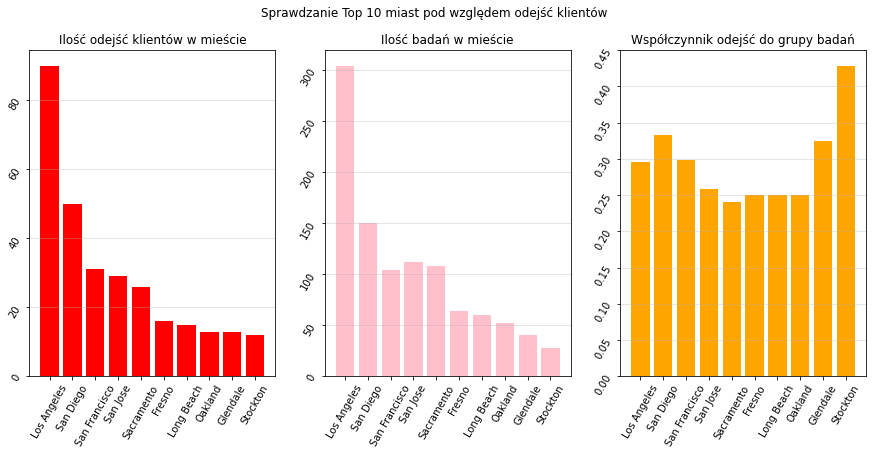

In [4]:
city_churn['comp'] = city_churn['sum'] / city_churn['size']
city_churn = city_churn[city_churn != 0].sort_values(by='sum', ascending=False)
y_churn = city_churn['sum'].head(10).values
y_size = city_churn['size'].head(10).values
y_comp = city_churn['comp'].head(10).values

fig, ax = plt.subplots(1, 3, figsize=(15,6))

ax[0].bar(X, y_churn, color="red")
ax[0].set_title("Ilość odejść klientów w mieście")

ax[1].bar(X, y_size, color="pink")
ax[1].set_title("Ilość badań w mieście")

ax[2].bar(X, y_comp, color="orange")
ax[2].set_title("Współczynnik odejść do grupy badań")

for bar in ax:
    bar.tick_params(labelrotation=60)
    bar.grid(True, axis="y", alpha=0.4)
    
fig.suptitle("Sprawdzanie Top 10 miast pod względem odejść klientów")

plt.show()

Możemy zobaczyć, że `Stockton` ma nawiększą ilość odejść w stosunku do badanych danych. Można również spojrzeć na `San Diego`, 
ma on o wiele większą ilość danych oraz drugi z kolei współczynnik odejść.

### Hierarchical clustering
Grupowanie w clustry 20 miast z nawiększą ilością odejść

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram

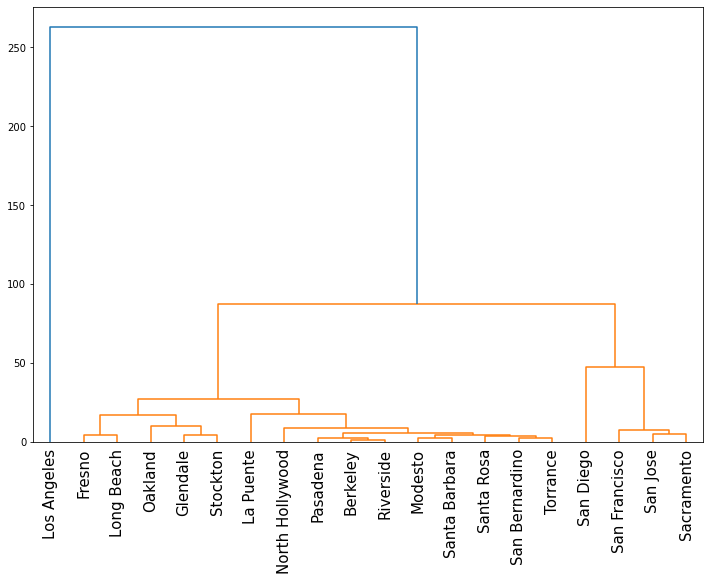

In [6]:
values = city_churn.sort_values(by='sum', ascending=False)
city_name = values.index[0:20]
values.index = range(1, len(values) + 1)
values = values[0:20]

plt.rcParams["figure.figsize"] = (12, 8)

mergings = linkage(values, method='average')
dendrogram(mergings,
          labels = city_name,
          leaf_rotation=90,
          leaf_font_size=15)
plt.show()

Możemy zobaczyć że Los Angeles jest tak duże, że tworzy osobny klaster i zaburza inne wyniki. Aby wizualizacja była bardziej przejrzysta zostanie on usunięty.

In [7]:
city_name = city_name.drop('Los Angeles')
values = values[1:20]

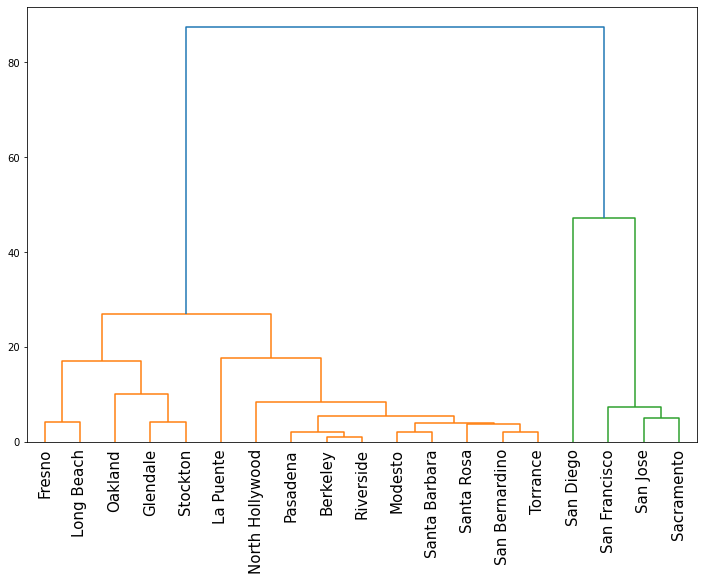

In [8]:
mergings = linkage(values, method='average')
dendrogram(mergings,
          labels = city_name,
          leaf_rotation=90,
          leaf_font_size=15)
plt.show()

Tutaj możemy zobaczyć że wyróżniają nam się już dwa klastry. Jeden z nich zawiera zdecydowanie więcej miast. Jeśli porównamy te wyniki z poprzednimi wizualizacjami możemy zobaczyć, że grupa zielona to miasta, które mają więszką ilość obeserwacji oraz większą największą liczbę odejść klientów. Firma może użyć tych grup aby wyciągnąć informacje na temat miast, które są krytyczne pod względem odejść klientów. 

In [9]:
from scipy.cluster.hierarchy import fcluster

In [10]:
labels = fcluster(mergings, t=50, criterion='distance')
city_clusters = pd.DataFrame({'City': city_name, 'Cluster' : labels}, index=range(1, len(labels) + 1))
city_clusters

,City,Cluster
1,San Diego,2
2,San Francisco,2
3,San Jose,2
4,Sacramento,2
5,Fresno,1
6,Long Beach,1
7,Oakland,1
8,Glendale,1
9,Stockton,1
10,Modesto,1


Powyżej można jeszcze zobaczyć w tabelce, które miasto przynależy do którego klastra. Funkcją fcluster w zalezności od potrzeby możemy wyciągnąć więcej klas w zależności od tego jaki dystans pomiędzy klastrami `t` jest nam odpowiadający

### Podział na zbiory

Aby dokładniej przeewaluować model zbiór zostanie podzielony na uczący i testowy w stosunku 80:20

In [11]:
X = df.drop(['City', 'Churn Value', 'Churn Score', 'CLTV'], axis=1).values
y = df['Churn Value'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Przygotowanie słownika na podsumowanie wyników modeli

In [12]:
acc_modeli = {}

### Regresja logistyczna

Modele zostaną zbudowane za pomocą `pipeline`, który pozwala łączyć kilka czynności w jedną całość. W pierwszej kolejności zostanie użyta regresja logistyczna, która jest praktycznie stworzona dla problemów klasyfikacyjnych. Zostanie użyta na danych po skalowaniu oraz jej wartości zostaną zoptymalizowane za pomocą `GridSearchCV`. Do schowania powiadomień o błędnym dopasowaniu parametrów przy GridSearchCV użyty zostanie modół `warnings`, którego uzywa `sklearn` do pokazywania ostrzeżeń

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import warnings

In [14]:
logreg = LogisticRegression()

param_grid = {"solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             "penalty": ['l1', 'l2', 'elasticnet', 'none'],
             "C": [0.2, 0.5, 1, 2, 3, 5]}

warnings.filterwarnings('ignore')
cv = GridSearchCV(logreg, param_grid=param_grid, cv=5)
cv.fit(X_train, y_train)

logreg.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print(f"Najlepsze parametry regresji: {cv.best_params_}")
print(f"Najlepsze accuracy regresji: {cv.best_score_}")
print(f"Predykcja z najlepszego modelu {cv.score(X_test, y_test)} \n")
acc_modeli['Regresja Logistyczna'] = cv.score(X_test, y_test)

print(f"Predykcja na niedostosowanym modelu Logistic Regression {logreg.score(X_test, y_test)}")

print(classification_report(y_test, y_pred, target_names=["0", "1"]))

y_pred_proba_logreg = cv.predict_proba(X_test)[:,1]
fprlog, tprlog, thresholdlog = roc_curve(y_test, y_pred_proba_logreg)

Najlepsze parametry regresji: {'C': 0.2, 'penalty': 'l2', 'solver': 'liblinear'}
Najlepsze accuracy regresji: 0.8074666666666666
Predykcja z najlepszego modelu 0.8244491826581379 

Predykcja na niedostosowanym modelu Logistic Regression 0.828002842928216
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1027
           1       0.72      0.57      0.64       380

    accuracy                           0.82      1407
   macro avg       0.79      0.74      0.76      1407
weighted avg       0.82      0.82      0.82      1407



W tym przykładzie dostosowanie parametrów nie wprowadziło istotnej różnicy i proces jest lepszy o około 0,05pp. Natomiast model osiągnął dokładność na poziomie 80%

### Drzewo decyzyjne

Kolejnym modelem, który zostanie wybrany do testowania predykcji danych jest `Decision Tree`. Tak jak w poprzednim modelu za pomocą `GridSearchCV` zostaną dostosowane parametry modelu. W modelu nie zostanie wykonane skalowanie ponieważ nie jest on wrażliwy na wariancje.

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
tree = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy'],
             'max_depth': [2, 3, 5, 7, 10],
             'min_samples_split': [4, 6, 8, 12, 15],
             'min_samples_leaf': [3, 4, 5, 8, 10]}
cv = GridSearchCV(tree, param_grid=param_grid, cv=5)

warnings.filterwarnings('ignore')
cv.fit(X_train, y_train)
tree.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print(f"Najlepsze parametry regresji: {cv.best_params_}")
print(f"Najlepsze accuracy regresji: {cv.best_score_}")
print(f"Predykcja z najlepszego modelu {cv.score(X_test, y_test)} \n")
acc_modeli['Drzewo Decyzyjne'] = cv.score(X_test, y_test)

print(f"Predykcja na niedostosowanym modelu drzewa decyzyjnego {tree.score(X_test, y_test)}")

print("Raport z klasyfikacji dla modelu \n")
print(classification_report(y_test, y_pred, target_names=["0", "1"]))

y_pred_proba_tree = cv.predict_proba(X_test)[:,1]
fprtree, tprtree, thresholdtree = roc_curve(y_test, y_pred_proba_tree)

Najlepsze parametry regresji: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 4}
Najlepsze accuracy regresji: 0.7904
Predykcja z najlepszego modelu 0.8052594171997157 

Predykcja na niedostosowanym modelu drzewa decyzyjnego 0.7228144989339019
Raport z klasyfikacji dla modelu 

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1027
           1       0.66      0.57      0.61       380

    accuracy                           0.81      1407
   macro avg       0.76      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407



### KNN
Ostatnim modelem, który przerobimy jest KNN z dostosowaniem parametrów i skalowaniem wartości w pipeline.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 

In [18]:
knn = KNeighborsClassifier()
scaler = StandardScaler()

steps = [("scaler", scaler),
         ("knn", knn)]
pipeline = Pipeline(steps)

param_grid = {"knn__n_neighbors": [4, 6, 8, 12, 20],
             "knn__algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
             "knn__leaf_size": [30, 35, 40, 50]}
cv = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
cv.fit(X_train, y_train)

knn.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print(f"Najlepsze parametry regresji: {cv.best_params_}")
print(f"Najlepsze accuracy regresji: {cv.best_score_}")
print(f"Predykcja z najlepszego modelu {cv.score(X_test, y_test)} \n")
acc_modeli['KNN'] = cv.score(X_test, y_test)

print(f"Predykcja na niedostosowanym modelu K-nearest neighbors: {knn.score(X_test, y_test)}")

print(classification_report(y_test, y_pred, target_names=["0", "1"]))

y_pred_proba_knn = cv.predict_proba(X_test)[:,1]
fprknn, tprknn, thresholdtree = roc_curve(y_test, y_pred_proba_knn)

Najlepsze parametry regresji: {'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__n_neighbors': 20}
Najlepsze accuracy regresji: 0.7896888888888889
Predykcja z najlepszego modelu 0.798862828713575 

Predykcja na niedostosowanym modelu K-nearest neighbors: 0.7789623312011372
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1027
           1       0.67      0.50      0.57       380

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407



### Krzywe ROC i AUC modeli

In [19]:
from sklearn.metrics import roc_auc_score

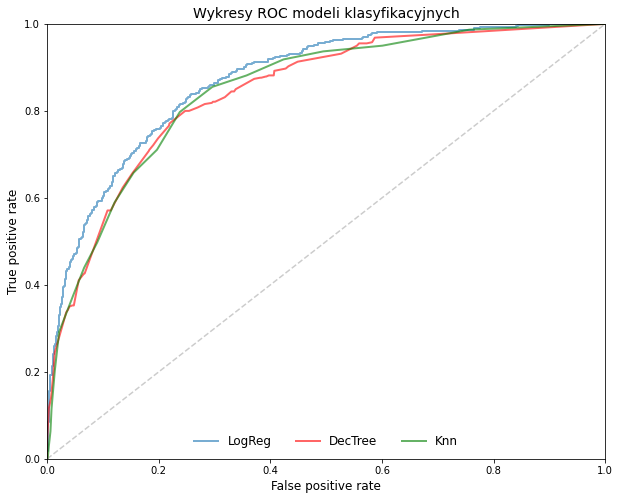

LogReg AUC: 	 0.8717496028288834
Tree AUC: 	 0.8452711013170706
Knn AUC:	 0.8481179213857428


In [20]:
plt.figure(figsize=(10,8))

plt.plot(fprlog, tprlog, label="LogReg", lw=2, alpha=0.6)
plt.plot(fprtree,tprtree, label="DecTree", color="red", lw=2, alpha=0.6)
plt.plot(fprknn, tprknn, label="Knn", color="green", lw=2, alpha=0.6)

plt.legend(frameon=False, loc=8, ncol=3, fontsize=12)


plt.axline((0,0), (1,1), color='gray', alpha=0.4, ls='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.title("Wykresy ROC modeli klasyfikacyjnych", fontsize=14)

plt.show()

print(f'LogReg AUC: \t {roc_auc_score(y_test, y_pred_proba_logreg)}')
print(f'Tree AUC: \t {roc_auc_score(y_test, y_pred_proba_tree)}')
print(f'Knn AUC:\t {roc_auc_score(y_test, y_pred_proba_knn)}')

lista_auc = [roc_auc_score(y_test, y_pred_proba_logreg), roc_auc_score(y_test, y_pred_proba_tree),
                           roc_auc_score(y_test, y_pred_proba_knn)]

### Podsumowanie wartości modeli

In [38]:
podsumowanie = pd.DataFrame(acc_modeli.values(), columns=['accuracy'], index=acc_modeli.keys())
podsumowanie['AUC'] = lista_auc
podsumowanie = podsumowanie.round(2)
print(podsumowanie)
print(f"Miasta na które powinno się zwrócić uwagę: ", end="")
print(", ".join(list(city_clusters[city_clusters['Cluster'] == 2]['City'])))

                      accuracy   AUC
Regresja Logistyczna      0.82  0.87
Drzewo Decyzyjne          0.81  0.85
KNN                       0.80  0.85
Miasta na które powinno się zwrócić uwagę: San Diego, San Francisco, San Jose, Sacramento


Na podsumowaniu możemy zobaczyć, że najlepiej dopasowanym modelem do naszych danych pod względem wyników z accuracy i AUC jest regresja logistyczna. W naszym przypadku nie jest ważniejsza predykcja, którejś klasy więc nie bierzemy pod uwagę analizy wyników z raportu klasyfikacyjnego. Wyżej zostały również wytypowane za pomocą klastów miasta, w których mamy największą liczbę osób oraz wysoki współczynnik odejść klientów. Na nich firma powinna się najbardziej skupić aby ograniczyć w tych miastach odejścia klientów.